In [1]:
# Imports
import glob
import numpy as np
from nilearn import image, plotting
from nilearn.image import new_img_like
import os
import scipy.io

C:\Users\davide\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
C:\Users\davide\anaconda3\lib\site-packages\nilearn\datasets\__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast' #main folder with data
bck_img_map = image.load_img(os.path.join(main_folder, 'MNI152_T1_1mm_Brain.nii')) #Background for plotting purposes

#List of subjects
subjects = ['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','22','23','24']

#subjects = ['01','02']

dcm_data_day1_path = os.path.join(main_folder,'Day1_all_EPvalues.mat') #mat file with DCM results of day 1
dcm_data_day1 = scipy.io.loadmat(dcm_data_day1_path)
#NB this file contains results for all 22 subjects for all 3 polarities (anodal, cathodal and sham)
#And the order is anodal, cathodal and sham for each subject (so I'm only interested in matrices 0, 3, 6 ... etc)

In [3]:
#Loading ROIs
m1_path = os.path.join(main_folder,'rois','m1.nii')
th_path = os.path.join(main_folder,'rois','th.nii')
m1 = image.load_img(m1_path)
th = image.load_img(th_path)

In [14]:
pos_dcm_res = 0 #Position of the DCM results for subject 1, day 1 (anodal)

# Where I'll save m1 self connections and all th->m1
all_m1selfcon = []
all_thm1 = []
all_thselfcon = []
all_m1th = []

# Where I'll save emag values for m1 and th for each subject (means, medians, max values)
all_m1_emag_means = []
all_th_emag_means = []
all_m1_emag_medians = []
all_th_emag_medians = []
all_m1_emag_max = []
all_th_emag_max = []

# I am also going to store all the Emag maps in a multi-dimentional array, for plotting purposes
all_emag_maps = []

for sbj in subjects:
    path = 'D:\\roast-chapter3\wp2a_copy\sub-' + sbj
    print('Analysing subject: ' + sbj + '. Path: ' + path)
    
    #Loading ROAST Electric field magnitude simulation (V/m)
    emag_map = image.load_img(glob.glob(path+ '/wsub-*_T1_*_emag.nii'))    
    emag_data = emag_map.get_fdata().reshape([157,189,156]) # needed to drop 4th dimention in the array (that shouldn't be there)
    emag_map = new_img_like(emag_map,emag_data) 
    
    # Applying fwhm smoothing to the electric field magnitude map. Kernel 4x4x4
    emag_map_smoothed = image.smooth_img(emag_map, fwhm=4) # Emag map

    # Loading masks containing grey matter, white matter and csf
    grey_matter = image.load_img(glob.glob(path+ '/wc1sub*.nii')).get_fdata().reshape([157,189,156]) 
    white_matter = image.load_img(glob.glob(path+ '/wc2sub*.nii')).get_fdata().reshape([157,189,156])
    csf = image.load_img(glob.glob(path+ '/wc3sub*.nii')).get_fdata().reshape([157,189,156])
    
    # Resampling MNI anatomical file to emag map (so that they have the same shape)
    mni_resampled = image.resample_to_img(bck_img_map, emag_map, interpolation = 'nearest')    
    
    #Emag map masked (to exclude the skull, and keep only values of voxels in the brain)
    emag_map_masked = image.math_img("np.where(img2 != 0, img, 0)", img=emag_map_smoothed, img2 = mni_resampled)
    
    # Resampling ROIs to the dimention of the emag map
    m1_resampled = image.resample_to_img(m1, emag_map_masked, interpolation = 'nearest')
    th_resampled = image.resample_to_img(th, emag_map_masked, interpolation = 'nearest')
    
    #Loading DCM results for the subject
    this_dcm = np.array(dcm_data_day1['ALLEP'][0][pos_dcm_res].todense().reshape((4,4))).T
    #Transposing is needed because the PEB lists values column by row and not row by column...
    
    print('DCM matrix')
    print(this_dcm) # If you want to see the whole connectivity matrix for each subject
    
    # DCM connectivities I'm interested in 
    m1m1 = this_dcm[0][0]
    thm1 = this_dcm[0][1]
    thth = this_dcm[1][1]
    m1th = this_dcm[1][0]
    
    # Saving the DCM values into separate lists
    all_m1selfcon.append(m1m1)
    all_thm1.append(thm1)
    all_m1th.append(m1th)
    all_thselfcon.append(thth) 
    
    #print('M1<->M1 connectivity: ' + str(m1m1))
    #print('Th<->Th connectivity: ' + str(thth))
    #print('M1<->th connectivity: ' + str(m1th))
    #print('Th<->M1 connectivity: ' + str(thm1))
    
    # Masking emag maps with M1 and Th rois
    emag_masked_m1 = image.math_img("img * img2", img=emag_map_masked, img2 = m1_resampled) #Applying m1 mask
    emag_masked_th = image.math_img("img * img2", img=emag_map_masked, img2 = th_resampled) #Applying th mask
    
    # Assigning nans to zeros to exclude non M1/Th voxels from the calculation of the mean
    emag_masked_m1_nans = np.where(m1_resampled.get_fdata() == 0, np.nan, emag_masked_m1.get_fdata())
    emag_masked_th_nans = np.where(th_resampled.get_fdata() == 0, np.nan, emag_masked_th.get_fdata())

    # Calculating means, medians and max values
    m1_emag_mean = np.nanmean(emag_masked_m1_nans)
    th_emag_mean = np.nanmean(emag_masked_th_nans)
    m1_emag_median = np.nanmedian(emag_masked_m1_nans)
    th_emag_median = np.nanmedian(emag_masked_th_nans)
    m1_emag_max = np.nanmax(emag_masked_m1_nans)
    th_emag_max = np.nanmax(emag_masked_th_nans)
       
    # Saving means, medians and max values into lists
    all_m1_emag_means.append(m1_emag_mean)
    all_th_emag_means.append(th_emag_mean)   
    all_m1_emag_medians.append(m1_emag_median)
    all_th_emag_medians.append(th_emag_median)  
    all_m1_emag_max.append(m1_emag_max)
    all_th_emag_max.append(th_emag_max)   
    
    print('Mean Electric field in M1: ' + str(round(m1_emag_mean,3)))
    print('Mean Electric field in Th: ' + str(round(th_emag_mean,3)))
    print('Median Electric field in M1: ' + str(round(m1_emag_median,3)))
    print('Median Electric field in Th: ' + str(round(th_emag_median,3)))
    print('Max Electric field in M1: ' + str(round(m1_emag_max,3)))
    print('Max Electric field in Th: ' + str(round(th_emag_max,3)))
    print('\n')
    
    # For displaying purposes only I am smoothing the MNI template      
    if not 'bck_img_map_smoothed' in locals():
        bck_img_map_smoothed = image.smooth_img(bck_img_map, fwhm=2) # MNI template
    
    all_emag_maps.append(emag_map_masked)
    
    # Scroll down to see each individual EMAG map (if plot set to True)
    plot = False
    if plot:
        display = plotting.plot_roi(emag_map_masked,
                      bg_img = bck_img_map_smoothed,
                      dim = 0.5,
                      cmap = 'jet',
                      cut_coords = [-26,11,26],
                      threshold = 0.001,
                      vmin = 0,
                      vmax = 0.3,
                      alpha = 0.60,
                      draw_cross = False,
                      black_bg = False)

    pos_dcm_res += 3 #Moving to the next subject
    
    
    
# Saving results into two dictionaries
emag_all_results = {'Medians M1': all_m1_emag_medians,'Medians Th': all_th_emag_medians,
                    'Max values M1': all_m1_emag_max,'Max values Th': all_th_emag_max}

dcm_all_results = {'M1M1': all_m1selfcon, 'M1Th': all_m1th, 'ThTh': all_thselfcon, 'ThM1': all_thm1}

Analysing subject: 01. Path: D:\roast-chapter3\wp2a_copy\sub-01
DCM matrix
[[ 0.13432463  0.04696154  0.24495624  0.38939647]
 [-0.16799798  0.00206718  0.184325    0.23095108]
 [-0.10115816 -0.12736803  0.05412554  0.19228947]
 [-0.08099843 -0.0739737   0.14763501 -0.10626441]]
Mean Electric field in M1: 0.382
Mean Electric field in Th: 0.079
Median Electric field in M1: 0.15
Median Electric field in Th: 0.078
Max Electric field in M1: 3.751
Max Electric field in Th: 0.122


Analysing subject: 02. Path: D:\roast-chapter3\wp2a_copy\sub-02
DCM matrix
[[-0.29935992 -0.02368375  0.0092537   0.12082979]
 [-0.08284093 -0.03635242 -0.11989645  0.1347108 ]
 [ 0.07135024 -0.11527901  0.01910991 -0.0130884 ]
 [-0.02277834 -0.00379228 -0.09126552  0.01045775]]
Mean Electric field in M1: 0.344
Mean Electric field in Th: 0.078
Median Electric field in M1: 0.132
Median Electric field in Th: 0.077
Max Electric field in M1: 3.464
Max Electric field in Th: 0.12


Analysing subject: 03. Path: D:\roast-

DCM matrix
[[-0.04124589 -0.61578695  0.02581394  0.21931913]
 [-0.02386424 -0.03827567  0.02525227 -0.01376434]
 [ 0.0803409  -0.06617893 -0.07268267 -0.10183392]
 [ 0.04535569 -0.05481033 -0.00329332  0.03377906]]
Mean Electric field in M1: 0.377
Mean Electric field in Th: 0.102
Median Electric field in M1: 0.176
Median Electric field in Th: 0.104
Max Electric field in M1: 3.142
Max Electric field in Th: 0.145


Analysing subject: 20. Path: D:\roast-chapter3\wp2a_copy\sub-20
DCM matrix
[[-0.04543567  0.3941091  -0.37613843  0.23768894]
 [ 0.10571178 -0.04580816 -0.01738682 -0.12957775]
 [ 0.59849973 -0.21100979 -0.03055114 -0.01067367]
 [ 0.05216951  0.02295077 -0.08188095 -0.05856325]]
Mean Electric field in M1: 0.307
Mean Electric field in Th: 0.075
Median Electric field in M1: 0.138
Median Electric field in Th: 0.075
Max Electric field in M1: 3.032
Max Electric field in Th: 0.117


Analysing subject: 22. Path: D:\roast-chapter3\wp2a_copy\sub-22
DCM matrix
[[-0.3058823  -0.03695552

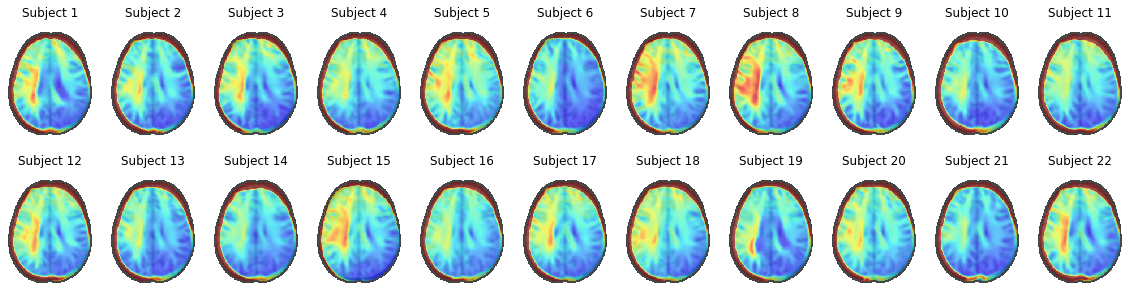

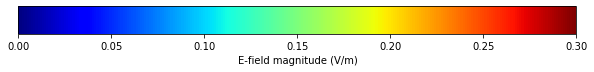

In [6]:
# create a figure with multiple axes to plot each Emag map
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=11, figsize=(20,5))

vmin, vmax = 0, 0.3 # Color map min and max
# axes is a 2 dimensional numpy array
subject = 0
for ax in axes.flatten():
    display = plotting.plot_roi(all_emag_maps[subject],
              bg_img = bck_img_map_smoothed,
              display_mode = 'z',
              annotate = False,
              dim = 0.5,
              cmap = 'jet',
              cut_coords = [28],
              threshold = 0.001,
              vmin = vmin,
              vmax = vmax,
              alpha = 0.60,
              draw_cross = False,
              black_bg = False,
              axes = ax)
    ax.title.set_text('Subject ' + str(subject + 1))
    subject += 1
    
# Colorbar for the above brain plots
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='E-field magnitude (V/m)')    
    

In [7]:
# Correlation between connectivity measures and Electric field magnitude medians and max values

for emag_measure in emag_all_results:
    for dcm_con in dcm_all_results:
        print('Correlating ' + emag_measure + ' with ' + dcm_con)
        x = np.transpose(emag_all_results[emag_measure])
        y = np.transpose(dcm_all_results[dcm_con])
        r,p  = scipy.stats.pearsonr(x, y)    # Pearson's r
        if p > 0.05: 
            print('Not sig. p value: ' + str(round(p,6)) + ', r=' + str(round(r,6)))
        if p < 0.05: 
            print('Sig. p value: ' + str(round(p,6)) + ', r=' + str(round(r,6)))   
        print('\n')

Correlating Medians M1 with M1M1
Not sig. p value: 0.249488, r=0.256354


Correlating Medians M1 with M1Th
Not sig. p value: 0.388292, r=-0.193479


Correlating Medians M1 with ThTh
Sig. p value: 0.01349, r=0.518199


Correlating Medians M1 with ThM1
Not sig. p value: 0.14269, r=-0.322925


Correlating Medians Th with M1M1
Not sig. p value: 0.286513, r=0.237832


Correlating Medians Th with M1Th
Not sig. p value: 0.793723, r=-0.059152


Correlating Medians Th with ThTh
Sig. p value: 0.003324, r=0.597449


Correlating Medians Th with ThM1
Sig. p value: 0.006924, r=-0.558319


Correlating Max values M1 with M1M1
Not sig. p value: 0.328088, r=0.218733


Correlating Max values M1 with M1Th
Not sig. p value: 0.724257, r=-0.079747


Correlating Max values M1 with ThTh
Not sig. p value: 0.517991, r=0.145583


Correlating Max values M1 with ThM1
Not sig. p value: 0.957001, r=0.012208


Correlating Max values Th with M1M1
Not sig. p value: 0.335113, r=0.215653


Correlating Max values Th with M

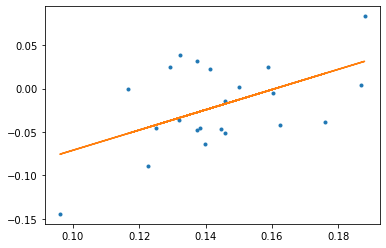

In [8]:
# Example of a plot for a correlation that is significant
x = np.transpose(emag_all_results['Medians M1'])
y = np.transpose(dcm_all_results['ThTh'])

from numpy.polynomial.polynomial import polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

C:\Users\davide\anaconda3\lib\site-packages\seaborn\utils.py:178: FutureWarning: This function is deprecated and will be removed in a future version
  warnings.warn(msg, FutureWarning)


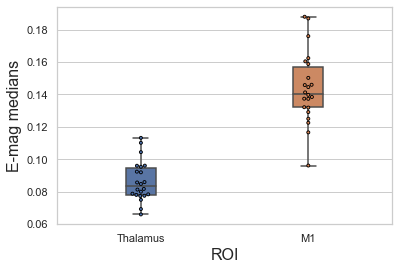

In [9]:
# Plotting electric field medians for M1 and Th
import seaborn as sns, matplotlib.pyplot as plt, operator as op

emag_results_toplot = {'M1': all_m1_emag_medians,'Thalamus': all_th_emag_medians}

sorted_keys, sorted_vals = zip(*sorted(emag_results_toplot.items(), key=op.itemgetter(1)))

sns.set(context='notebook', style='whitegrid')
sns.utils.axlabel(xlabel="ROI", ylabel="E-mag medians", fontsize=16)

sns.boxplot(data=sorted_vals, width=.18)
sns.swarmplot(data=sorted_vals, size=3, edgecolor="black", linewidth=.9)

# category labels
plt.xticks(plt.xticks()[0], sorted_keys)

plt.show()